In [20]:
from DLtools.Data import instant_data,intersection,del_less_col,station_sel,check_specific_col
from DLtools.feature_sel import call_mar
from DLtools.MachineLearning import test_stationarity,tsplot

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# Load data

In [21]:
###### SETTING AREA ################
loading = instant_data()
# df,mode,n_past,n_future = loading.hourly_instant(),'hour',24*7,72
df,mode,n_past,n_future = loading.daily_instant(),'day',60,30

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
save_path = host_path
#######################################################
def scope_data(data):
    global start_p,stop_p
    # return del_less_col(data[start_p:stop_p],0.8)
    return data[start_p:stop_p]
#######################################################
df_r = scope_data(loading.df_r)
df_w = scope_data(loading.df_w)
df_wet = scope_data(loading.df_wet)
df_dam = scope_data(loading.df_d)

df_solar = df_wet[check_specific_col(df_wet,'solar')]
df_rain1h = df_wet[check_specific_col(df_wet,'rain1h')]
df_temp = df_wet[check_specific_col(df_wet,'temp')]
df_press = df_wet[check_specific_col(df_wet,'press')]
df_humid = df_wet[check_specific_col(df_wet,'humid')]
#######################################################
# df_r = scope_data(loading.df_r)

* Filter ratio 80%, interpolation NaN

In [22]:
data = df[start_p:stop_p]
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')
data  = call_mar(data,target,mode,cutoff=0.2)
print(len(data.columns))
data.columns


21


Index(['CPY017_wl', 'Dam_SK_WaterVol', 'DNP032_rain', 'YOM008_wl',
       'DNP032_temp', 'CHM002_wl', 'Dam_BH_Useable_WaterVol', 'VLGE15_rain',
       'PAS009_wl', 'CHM006_wl', 'YOM009_wl', 'VLGE15_press', 'DNP032_wl',
       'VLGE36_rain', 'DNP017_press', 'DNP055_humid', 'VLGE25_humid',
       'DNP017_temp', 'NAN008_wl', 'CPY011_wl', 'CPY012_wl'],
      dtype='object')

In [29]:
MARfile='./MAR/[CPY012]featurelist_MAR_daily_Fullreport.csv'
mar = pd.read_csv(MARfile)

cutoff =0.3
cutoff_mar = mar.loc[(mar['rss']>cutoff)|(mar['gcv']>cutoff)|(mar['nb_subset']>cutoff)]

In [31]:
cutoff_mar.drop_duplicates('feature')

,feature,rss,gcv,nb_subset,timestep
0,CPY011_wl,0.54,0.55,0.03,1
28,PAS009_wl,0.62,0.63,0.05,2
85,DNP017_press,0.41,0.42,0.03,4
148,NAN008_wl,0.46,0.46,0.03,6
229,VLGE15_press,0.40,0.40,0.06,9
256,VLGE15_rain,0.59,0.59,0.08,10
353,VLGE36_rain,0.50,0.50,0.06,14
407,CHM006_wl,0.53,0.53,0.03,16
431,CHM002_wl,0.46,0.47,0.03,17
559,Dam_BH_Useable_WaterVol,0.54,0.54,0.09,22


In [25]:
df_rainST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-rain.csv')
df_waterST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-water-level.csv')
df_weatherST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-weather-data-master/station_metadata.csv')

* filter ST only avaliable 80% data

In [26]:
def clean_list(df_st,sel_word):
    global data
    data_col = list(data.columns)
    data_col = [i.split("_") for i in data_col]
    _col =list()
    if sel_word=='':
        for i in data_col:_col.append(i[0])
    else:
        for i in data_col:
            if i[1]==sel_word : _col.append(i[0])
    dis_loc = intersection(_col,list(df_st['code']))
    df_st = df_st.loc[df_st['code'].isin(dis_loc)]
    return df_st

In [27]:
df_rainST = clean_list(df_weatherST,'rain1h')
df_waterST = clean_list(df_waterST,'wl')
df_pressST = clean_list(df_weatherST,'press')
CPY = df_waterST.loc[df_waterST['code']=='CPY012']


# Map display

In [126]:
import geopandas as gpd
path_w = "/home/song/Public/Song/Work/Thesis/data/map/Streams/River (PGIS).shp"
path_t = '/home/song/Public/Song/Work/Thesis/data/map/Th_map/thailand.shp'
watermap = gpd.read_file(path_w)
thaimap = gpd.read_file(path_t)

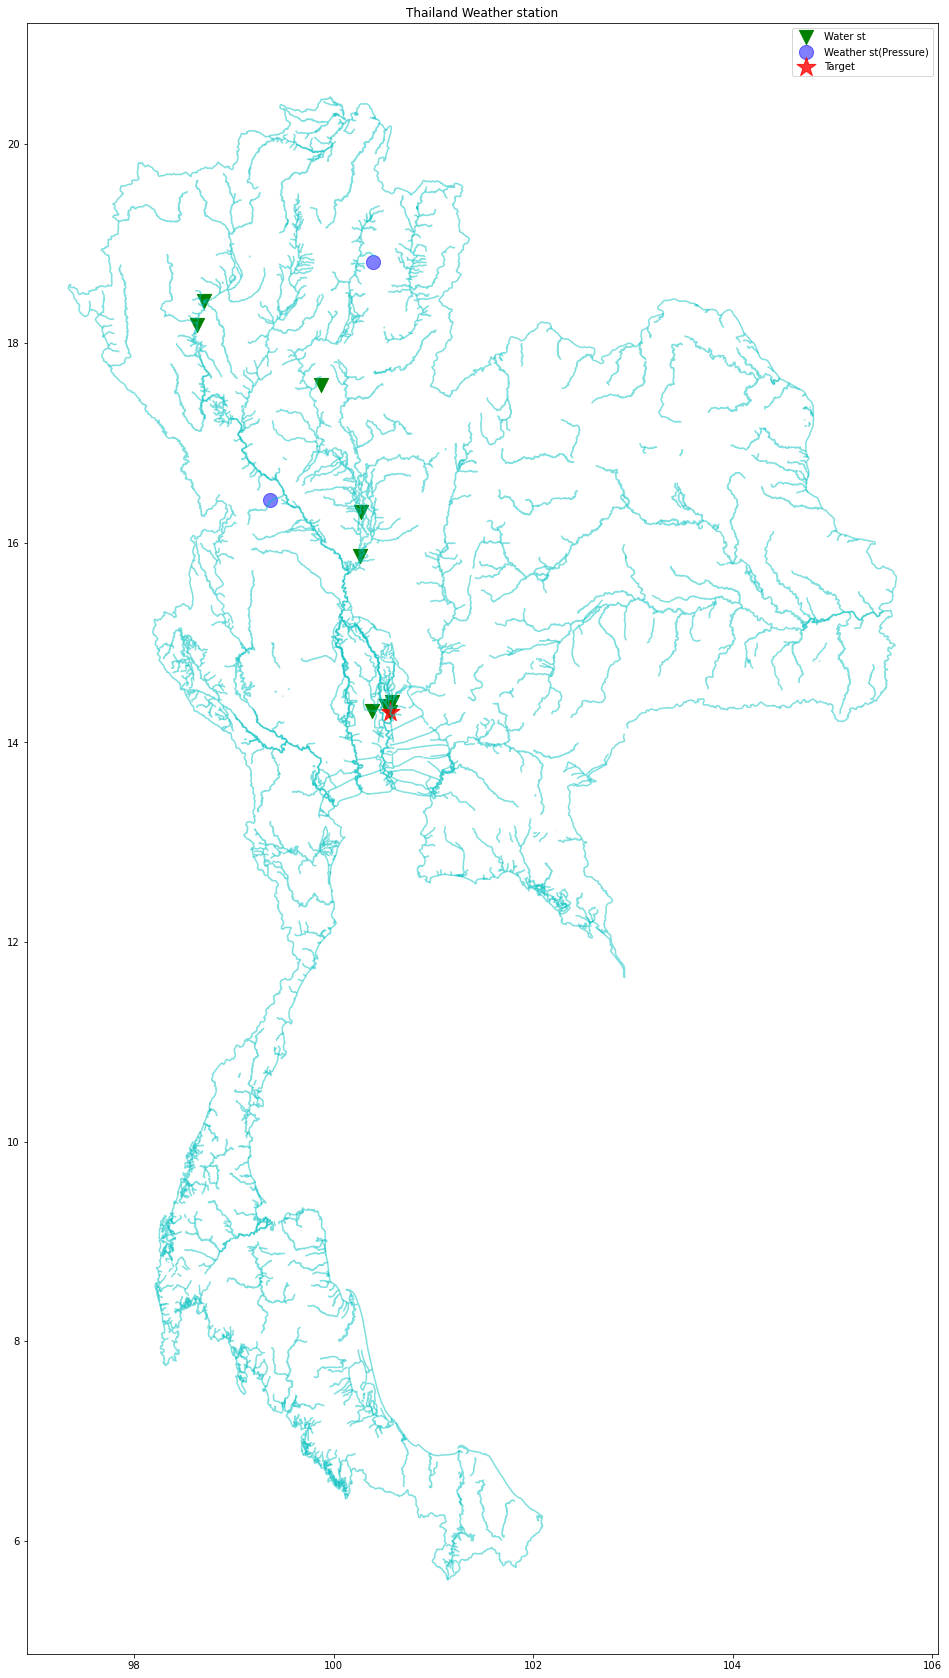

In [127]:
fig, ax = plt.subplots(1,figsize=(50,30))

# thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue',alpha=0.5)
# #station map
waterstation_map = gpd.GeoDataFrame(df_waterST, geometry=gpd.points_from_xy(df_waterST.long, df_waterST.lat))
CPY_station_map = gpd.GeoDataFrame(CPY, geometry=gpd.points_from_xy(CPY.long, CPY.lat))
rain_station_map = gpd.GeoDataFrame(df_rainST, geometry=gpd.points_from_xy(df_rainST.long, df_rainST.lat))
weather_station_map = gpd.GeoDataFrame(df_pressST, geometry=gpd.points_from_xy(df_pressST.long, df_pressST.lat))

ax.set_title('Thailand Weather station')
waterstation_map.plot(ax=ax, color='green',marker="v", markersize=200, legend=True, label= 'Water st')
rain_station_map.plot(ax=ax, color='orange',marker="^",markersize=200, legend=True,label='Rain st')
weather_station_map.plot(ax=ax, color='blue',marker="o", markersize=200, legend=True,alpha=0.5, label= 'Weather st(Pressure)')
CPY_station_map.plot(ax=ax, color='red',marker="*",markersize=400, legend=True,alpha=0.8,label='Target')
plt.legend(loc='upper right')
plt.savefig('watermap_day_mar30.png')

In [12]:
# fig, ax = plt.subplots(1,figsize=(7,12))
# thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
# water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue')
# # station
# rain_station_map = gpd.GeoDataFrame(df_rainST, geometry=gpd.points_from_xy(df_rainST.long, df_rainST.lat))

# ax.set_title('Thailand Rain station')
# rain_station_map.plot(ax=ax, color='orange',marker="x",markersize=5)
# CPY_station_map.plot(ax=ax, color='red',marker="o",markersize=25)
# plt.savefig('rainmap.png')